In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Data manipulation libraries
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,GridSearchCV

# Model evaluaion libraries
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report

# Classiication Models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from mlxtend.classifier import StackingCVClassifier

import optuna

# Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42

In [2]:
# Playground dataset train & test
P_train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Original dataset train & test
O_train_df = pd.read_csv('kindey stone urine analysis.csv')

In [3]:
# Combining original and playground datasets
train_df = pd.concat([P_train_df, O_train_df], axis=0)
train_df.drop(columns=["id"], inplace=True)

In [4]:
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = df.describe().T
    summary.drop(columns=["count","25%","50%","75%"], inplace=True)
    summary["mode"] = df.mode().values[0]
    summary["median"] = df.median()
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
#     summary.drop(labels="id", inplace=True)
    return summary

In [5]:
summary(P_train_df)

Dataset has 8 features and 414 examples.


,mean,std,min,max,mode,median,Unique,Missing,Duplicated,Types
id,206.500000,119.655756,0.000,413.00,0.000,206.500,414,0,0,int64
gravity,1.017894,0.006675,1.005,1.04,1.021,1.018,28,0,0,float64
ph,5.955459,0.642260,4.760,7.94,5.530,5.740,71,0,0,float64
osmo,651.545894,234.676567,187.000,1236.00,577.000,679.500,80,0,0,int64
cond,21.437923,7.514750,5.100,38.00,29.000,22.200,65,0,0,float64
urea,278.657005,136.442249,10.000,620.00,159.000,277.000,73,0,0,int64
calc,4.114638,3.217641,0.170,14.34,4.490,3.130,85,0,0,float64
target,0.444444,0.497505,0.000,1.00,0.000,0.000,2,0,0,int64


In [6]:
summary(O_train_df)

Dataset has 7 features and 79 examples.


,mean,std,min,max,mode,median,Unique,Missing,Duplicated,Types
gravity,1.018114,0.007239,1.005,1.04,1.02,1.018,29,0,0,float64
ph,6.028481,0.724307,4.760,7.94,5.40,5.940,70,0,0,float64
osmo,612.848101,237.514755,187.000,1236.00,577.00,594.000,77,0,0,int64
cond,20.813924,7.938994,5.100,38.00,23.60,21.400,64,0,0,float64
urea,266.405063,131.254550,10.000,620.00,159.00,260.000,73,0,0,int64
calc,4.138987,3.260051,0.170,14.34,1.16,3.160,75,0,0,float64
target,0.430380,0.498293,0.000,1.00,0.00,0.000,2,0,0,int64


In [7]:
# Combination dataset
summary(train_df)

Dataset has 7 features and 493 examples.


,mean,std,min,max,mode,median,Unique,Missing,Duplicated,Types
gravity,1.017929,0.006761,1.005,1.04,1.021,1.018,29,0,0,float64
ph,5.967160,0.655861,4.760,7.94,5.530,5.770,75,0,0,float64
osmo,645.344828,235.320087,187.000,1236.00,577.000,668.000,80,0,0,int64
cond,21.337931,7.579484,5.100,38.00,29.000,21.900,67,0,0,float64
urea,276.693712,135.568157,10.000,620.00,159.000,272.000,74,0,0,int64
calc,4.118540,3.221149,0.170,14.34,4.490,3.160,86,0,0,float64
target,0.442191,0.497151,0.000,1.00,0.000,0.000,2,0,0,int64


In [8]:
summary(test_df)

Dataset has 7 features and 276 examples.


,mean,std,min,max,mode,median,Unique,Missing,Duplicated,Types
id,551.500000,79.818544,414.000,689.000,414.000,551.500,276,0,0,int64
gravity,1.018330,0.006569,1.005,1.034,1.021,1.019,27,0,0,float64
ph,5.939312,0.607143,4.900,7.940,5.530,5.730,62,0,0,float64
osmo,654.891304,236.361932,187.000,1236.000,874.000,658.000,75,0,0,int64
cond,21.886594,7.346069,5.100,38.000,29.000,23.600,58,0,0,float64
urea,280.985507,134.877856,64.000,620.000,159.000,282.000,71,0,0,int64
calc,4.076848,3.088524,0.170,14.340,4.490,3.230,74,0,0,float64


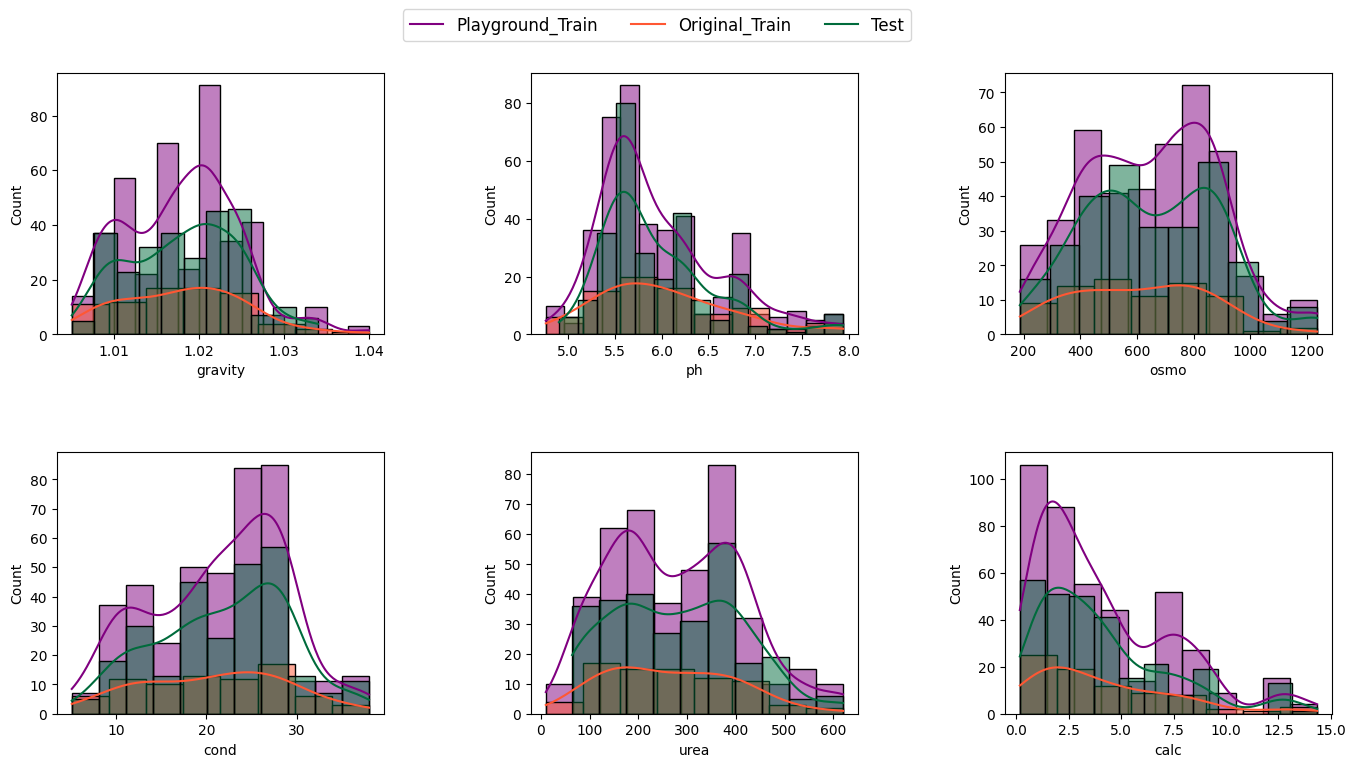

In [9]:
# Create multiple plots with a given size
fig = plt.figure(figsize=(15,12))

features = P_train_df.columns[1:-1]

# Create a countplot to evaluate the distribution
for i, feature in enumerate(features):
    ax = plt.subplot(3, 3, i+1)
    sns.histplot(x=feature, data=P_train_df, label="Playground_Train", color='#800080', ax=ax, alpha=0.5, kde=True)
    sns.histplot(x=feature, data=O_train_df, label="Original_Train", color='#FF5733', ax=ax, alpha=0.5, kde=True)
    sns.histplot(x=feature, data=test_df, label="Test", color='#006b3c', ax=ax, alpha=0.5, kde=True)
#     ax.set_xlabel(feature, fontsize=12)

# Create the legend
fig.legend(labels=['Playground_Train', 'Original_Train', 'Test'], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=12, ncol=3)

# Adjust the spacing between the subplots and the legend
fig.subplots_adjust(top=0.90, bottom=0.05, left=0.10, right=0.95, hspace=0.45, wspace=0.45)

plt.show()

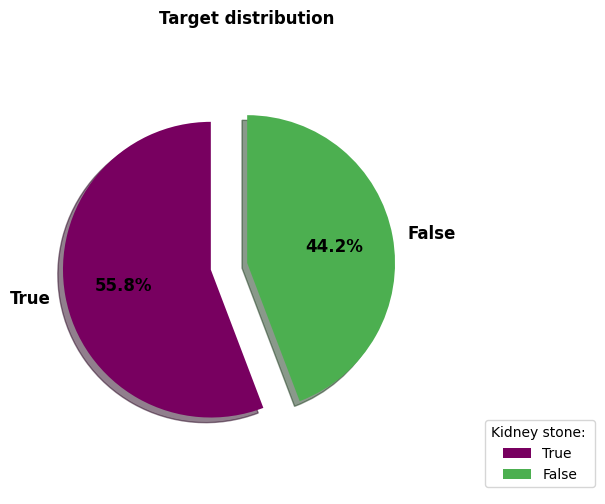

In [10]:
colorPal = ["#780060", "#4CAF50"]
piee = train_df['target'].value_counts()
mylabels = "True","False"
myexplode = [0.2, 0]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


patches, texts, autotexts = ax.pie(piee, autopct='%1.1f%%', explode = myexplode,
                                  labels = mylabels, shadow = True,
                                  colors = colorPal, startangle = 90,
                                  radius = 0.8)

ax.legend(patches, mylabels,
          title="Kidney stone: ",
          loc="lower left",
          fontsize=10,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
plt.setp(texts, size=12, weight="bold")

ax.set_title("Target distribution", fontsize = 12, weight="bold")

plt.show()

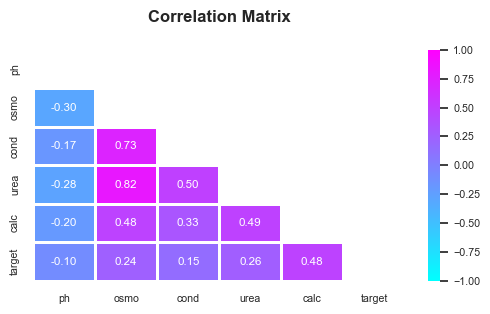

In [11]:
corr = train_df.iloc[:,1:].corr()

# create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
plt.figure(figsize=(6, 3))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=12, weight = 'bold', pad=20)
plt.show()

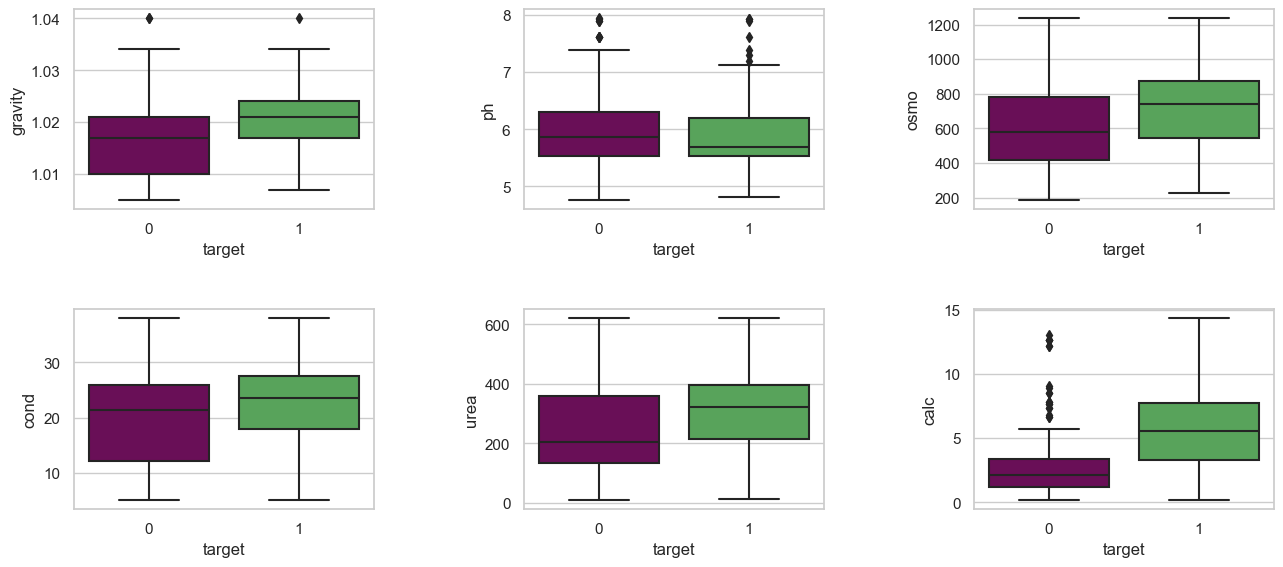

In [12]:
# Set the figure size
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")
# Create categorical features subplots
for i, feature in enumerate(features):
    ax = plt.subplot(3, 3, i+1)
    sns.boxplot(x="target", y=feature , data=P_train_df, ax=ax, palette=colorPal)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=.5, wspace=0.5)

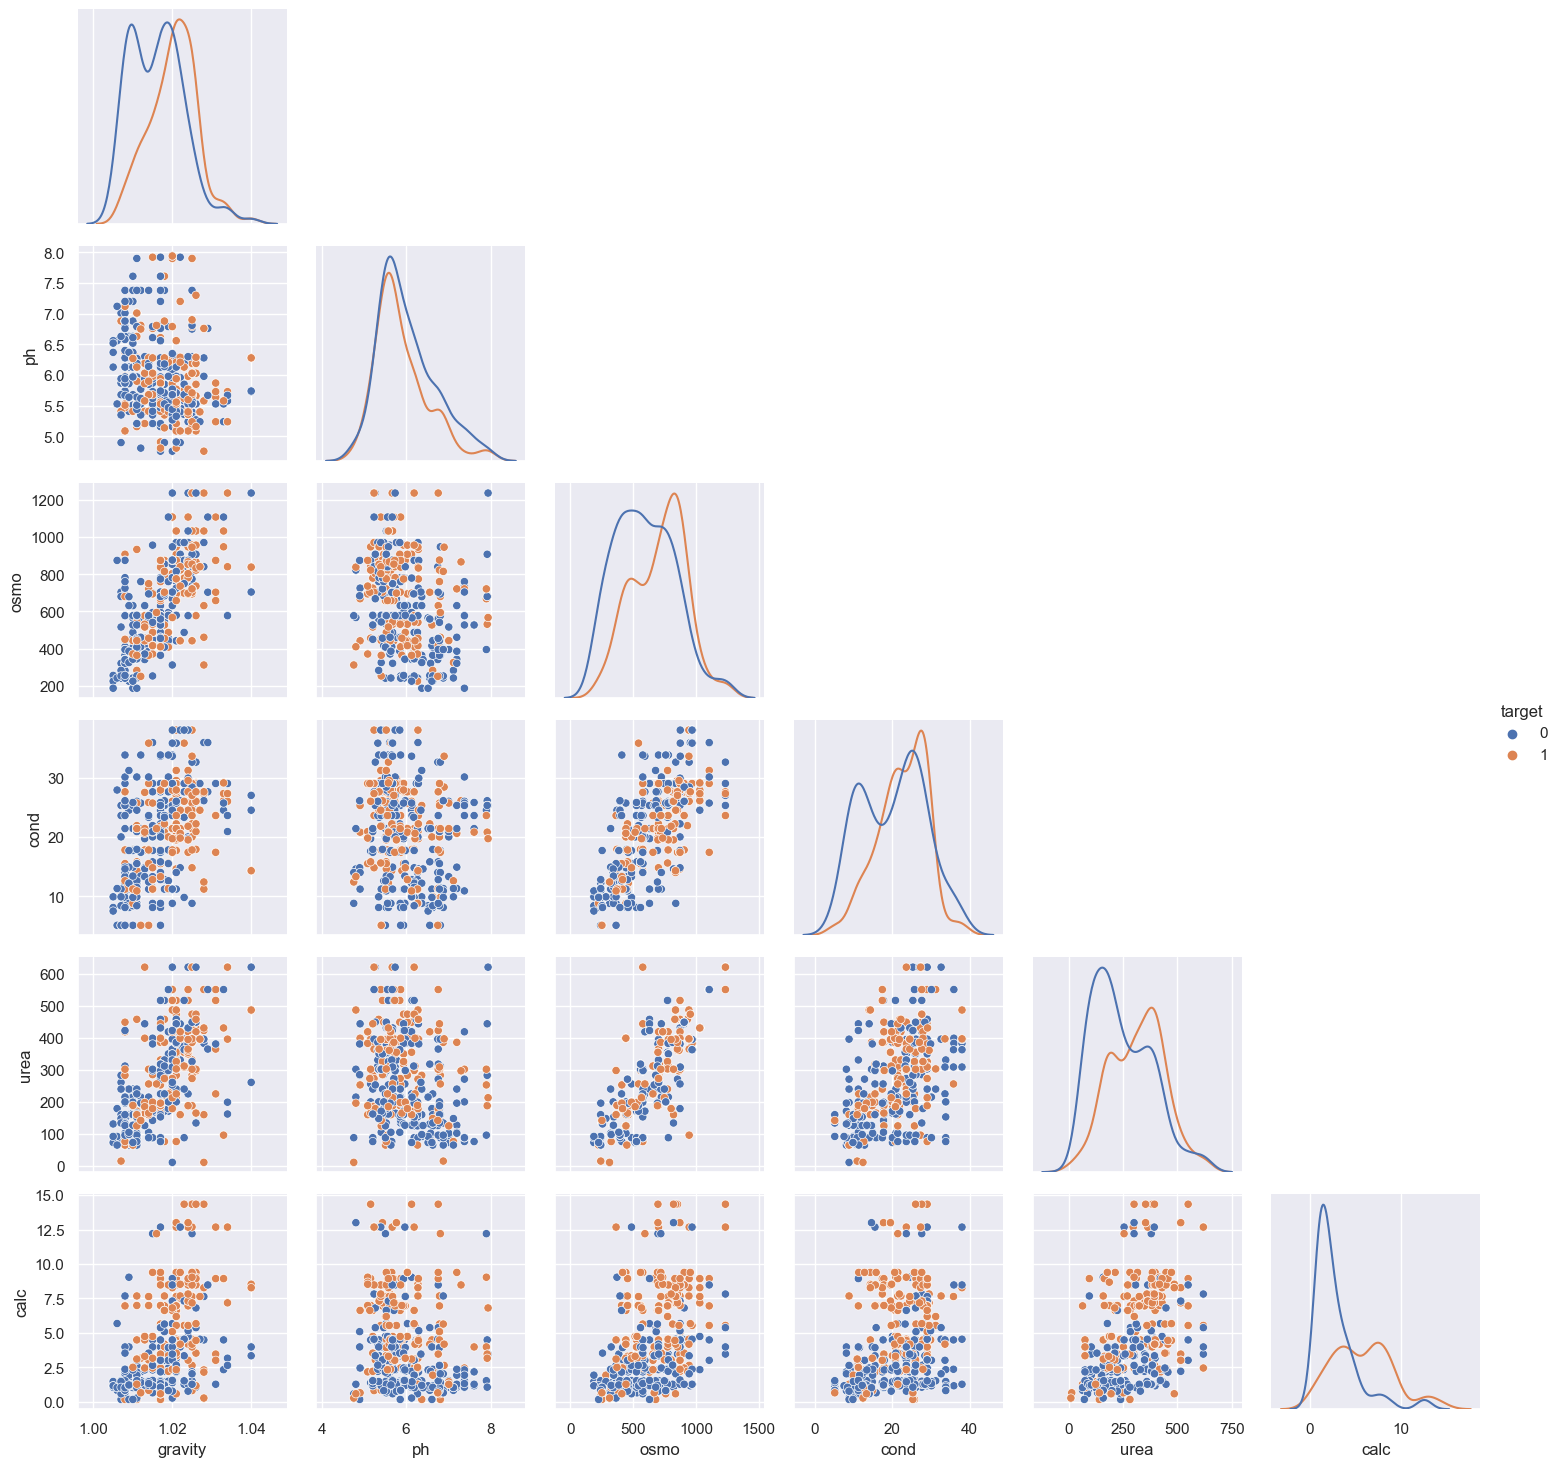

In [13]:
sns.set_theme(style="darkgrid")
g = sns.PairGrid(train_df, hue="target", diag_sharey=False, corner=True)
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [14]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
for  i in outlier_list:
    outlier_removal(train_df ,i)

In [15]:
def prepXy(df,X_label,y_label=None):
    selected_feat = []
    data = copy.deepcopy(df)
    
    # Feature Engineering
    
    
    # Ion product of calcium and urea
    data["ion_product"] = data["calc"] * data["urea"]

    # Calcium-to-urea ratio
    data["calcium_to_urea_ratio"] = data["calc"] / data["urea"]

    # Electrolyte balance
    data["electrolyte_balance"] = data["cond"] / (10 ** (-data["ph"]))

    # Osmolality-to-specific gravity ratio
    data["osmolality_to_sg_ratio"] = data["osmo"] / data["gravity"]

    # The product of osmolarity and density is created as a new property
    data['osmo_density'] = data['osmo'] * data['gravity']
    
    # ******************************************************************
    
    # Calculate ammonium concentration (assuming ammonium is not directly measured)
    data['ammonium_concentration'] = (data['gravity'] - 1.010) * (140 - (2 * data["ph"])) * 1.2

    # Calculate phosphate concentration (assuming phosphate is not directly measured)
    data['phosphate_concentration'] = (data['gravity'] - 1.010) * (32 - (0.06 * data["ph"]))

    # *****************************************************************
    # https://www.kaggle.com/code/brysonje/basic-before-complex-ideas/notebook
    data["gravity/ph"] = data["gravity"] / data["ph"]
    data["osmo/cond"] = data["osmo"] / data["cond"]
    data["gravity*ph"] = data["gravity"] * data["ph"]
    data["osmo*urea"] = data["osmo"] * data["urea"]
    data["cond_urea_ph"] = data["cond"] * data["urea"] / data["ph"]
    data["ph*osmo"] = data["ph"] * data["osmo"]
    data["cond*calc"] = data["cond"] * data["calc"]
    data["gravity/calc"] = data["gravity"] / data["calc"]

    # ____________________________________________________________________________
    # Converting pH column to categorical variable
    # Kudos to https://www.kaggle.com/lyasdemir
#     data['pH_cat'] = pd.cut(data['ph'], bins=[0, 4.5, 6.5, 8.5, 14], labels=[ 'sangat acidic' , 'acidic', 'neutral', 'basic' ])
#     dummies = pd.get_dummies(data['pH_cat'])
#     data = pd.concat([data, dummies], axis=1)
#     data.drop(['pH_cat', 'sangat acidic' , 'basic','neutral','ph'], axis=1, inplace=True)
    # ____________________________________________________________________________
    
    # Normalization
#     data = normalize(data, norm='l2', axis=0)
    
    # Split into features and target
    X = data[X_label].values
    
    if y_label is None:
        y = np.zeros(data.shape[0])
    else:
        y = np.ravel(data[y_label].values)

    # Scaling dataset
#     scaler = MinMaxScaler()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    


    return data,X,y

In [16]:
features = [c for c in train_df.columns if c!="target"]

# Define engineered features
eng_features = ['ion_product','calcium_to_urea_ratio','electrolyte_balance','osmolality_to_sg_ratio','osmo_density',
                   'ammonium_concentration','phosphate_concentration']
eng_features = ['ion_product','calcium_to_urea_ratio', 'electrolyte_balance', "osmolality_to_sg_ratio","osmo_density","gravity/ph","osmo/cond",
                "gravity*ph","osmo*urea","cond_urea_ph","ph*osmo","cond*calc","gravity/calc","phosphate_concentration","ammonium_concentration","acidic"]
features.extend(eng_features)

In [17]:
remove_col = ['acidic'] # add if want to remove features
for i in remove_col:
    features.remove(i)
    
print(features)

# Data preparation
new_train_df,X,y = prepXy(train_df,X_label=features,y_label=['target'])
new_test_df,X_,y_ = prepXy(test_df,X_label=features,y_label=None)

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'ion_product', 'calcium_to_urea_ratio', 'electrolyte_balance', 'osmolality_to_sg_ratio', 'osmo_density', 'gravity/ph', 'osmo/cond', 'gravity*ph', 'osmo*urea', 'cond_urea_ph', 'ph*osmo', 'cond*calc', 'gravity/calc', 'phosphate_concentration', 'ammonium_concentration']


Random Forest Classifier
                        precision    recall  f1-score   support

     Have Kidney stone       0.83      0.83      0.83         6
Dont have Kidney stone       0.80      0.80      0.80         5

              accuracy                           0.82        11
             macro avg       0.82      0.82      0.82        11
          weighted avg       0.82      0.82      0.82        11


XGboost
                        precision    recall  f1-score   support

     Have Kidney stone       0.75      0.50      0.60         6
Dont have Kidney stone       0.57      0.80      0.67         5

              accuracy                           0.64        11
             macro avg       0.66      0.65      0.63        11
          weighted avg       0.67      0.64      0.63        11


K Nearest Neighbour
                        precision    recall  f1-score   support

     Have Kidney stone       0.67      1.00      0.80         6
Dont have Kidney stone       1.00      0.4

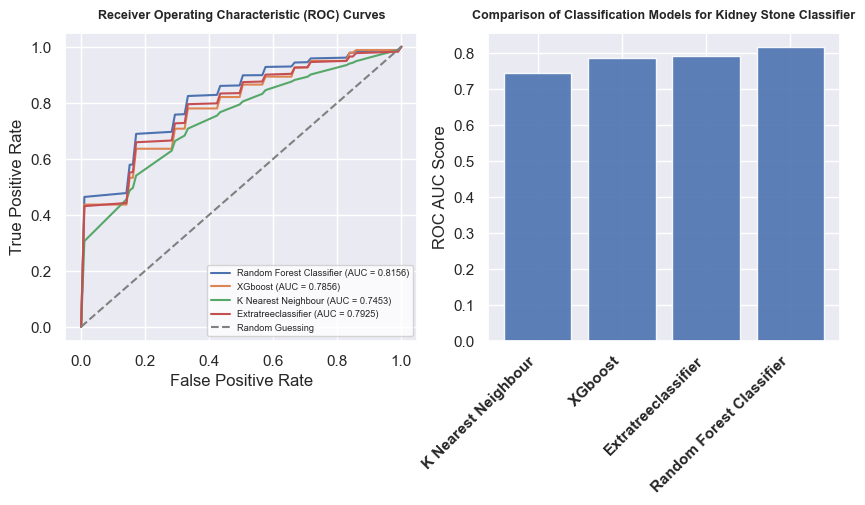

In [18]:
# set up k-fold cross-validation
kfold = RepeatedStratifiedKFold(n_splits=40, n_repeats=6, random_state=RANDOM_STATE)

# evaluate each model using cross-validation and compute ROC AUC scores
scores = []
classifiers = {
#     'Logistic Regression':LogisticRegression(),
    'Random Forest Classifier':RandomForestClassifier(random_state=RANDOM_STATE),
    'XGboost' : XGBClassifier(random_state=RANDOM_STATE),
    'K Nearest Neighbour': KNeighborsClassifier(),
    'Extratreeclassifier': ExtraTreesClassifier(random_state=RANDOM_STATE)
}

# Creating subplots for further evaluation
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.set_theme(style="whitegrid",font_scale=0.8)

for name, model in classifiers.items():
    
    model_scores,fprs,tprs = [],[],[]
    base_fpr = np.linspace(0, 1, 100)
    
    for train_idx, test_idx in kfold.split(X,y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        y_predict = model.predict(X_test)
        score = roc_auc_score(y_test, y_pred)
        model_scores.append(score)
        
        # Find and Store Roc curve fpr & tpr
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        fprs.append(fpr)
        tprs.append(tpr)
    
    # Plot roc curve
    mean_tpr = np.mean(tprs, axis=0)      
    ax1.plot(base_fpr, mean_tpr, label='{} (AUC = {:.4f})'.format(name, np.mean(model_scores)))

    # Add score of the model to the list
    scores.append((name, model_scores))
    
    # Print classification score of the model
    report = classification_report(y_test, y_predict, target_names=['Have Kidney stone', 'Dont have Kidney stone'], labels=[0, 1])
    print(f'{name}\n{report}\n')
    
# Create the roc_curve description
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curves',fontsize=9, weight = 'bold', pad=10)
ax1.legend(loc='lower right',fontsize='x-small')

# Find mean score of models and sort them and print the best model
names, model_scores = zip(*scores)
mean_scores = [np.mean(s) for s in model_scores]
comp = dict(zip(names,mean_scores))
sorted_comp = dict(sorted(comp.items(), key=lambda x: x[1]))
sorted_names = list(sorted_comp.keys())
sorted_mean_scores = list(sorted_comp.values())
print(f'The best model is {sorted_names[-1]} with a mean ROC AUC score of {sorted_mean_scores[-1]:.4f}')

# Creating a barplot to compare models
ax2.bar(sorted_names, sorted_mean_scores, align='center', alpha=0.9, ecolor='black', capsize=10)
ax2.set_ylabel('ROC AUC Score')
ax2.set_xticks(range(len(sorted_names)))
ax2.set_xticklabels(sorted_names, rotation=45, ha='right',weight = 'bold')
ax2.set_title('Comparison of Classification Models for Kidney Stone Classifier',fontsize=9, weight = 'bold', pad=10)

plt.show()

Logistic Regression
                        precision    recall  f1-score   support

     Have Kidney stone       0.71      0.83      0.77         6
Dont have Kidney stone       0.75      0.60      0.67         5

              accuracy                           0.73        11
             macro avg       0.73      0.72      0.72        11
          weighted avg       0.73      0.73      0.72        11


Random Forest Classifier
                        precision    recall  f1-score   support

     Have Kidney stone       0.83      0.83      0.83         6
Dont have Kidney stone       0.80      0.80      0.80         5

              accuracy                           0.82        11
             macro avg       0.82      0.82      0.82        11
          weighted avg       0.82      0.82      0.82        11


XGboost
                        precision    recall  f1-score   support

     Have Kidney stone       0.80      0.67      0.73         6
Dont have Kidney stone       0.67      0.8

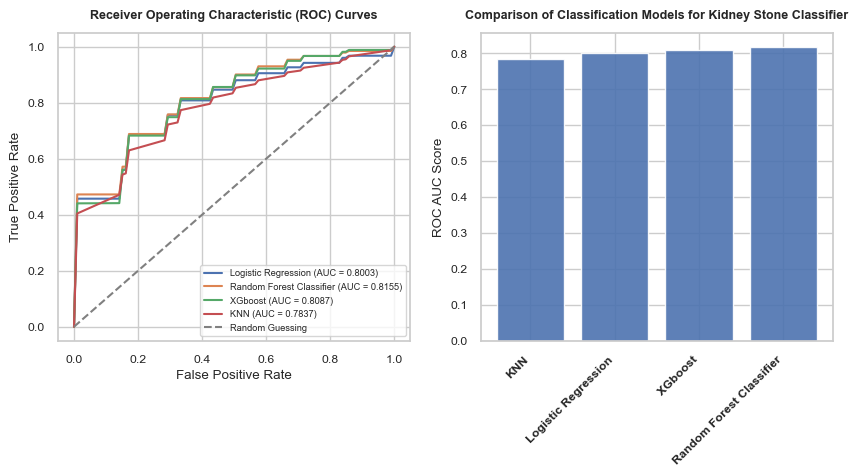

In [19]:
# Optuna params
RFParams = {    
    'max_depth': 12,
    'min_samples_split': 2,
    'min_samples_leaf': 3,
    'n_estimators': 325}
# Gridsearch params
RFParams = {'max_depth': 6, 'n_estimators': 80}
# Optuna params
XGBParams = {    
    'max_depth': 9,
    'learning_rate': 0.1,
    'min_child_weight': 4,
    'gamma': 0.0011477222533016578,
    'lambda': 0.1145277422236583,
    'alpha': 0.02267658572832824,
    'n_estimators': 100
}
# Gridsearch params which did better
XGBParams = {'n_estimators':400,'max_depth':8,'learning_rate':0.01}
# Kudos to [https://www.kaggle.com/code/usedpython/s3-ep12-logistic-regression] for optimized lr params
LRParams ={'C' : 0.4705441231048984, 'max_iter':10000, 'solver':'liblinear', 'penalty':'l1', 'fit_intercept':True}
# evaluate each model using cross-validation and compute ROC AUC scores
scores = []
classifiers = {
    'Logistic Regression':LogisticRegression(**LRParams,random_state=RANDOM_STATE),
    'Random Forest Classifier':RandomForestClassifier(**RFParams,random_state=RANDOM_STATE),
    'XGboost' : XGBClassifier(**XGBParams,random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=16)
}

# Creating subplots for further evaluation
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.set_theme(style="whitegrid",font_scale=0.8)

for name, model in classifiers.items():
    
    model_scores,fprs,tprs = [],[],[]
    base_fpr = np.linspace(0, 1, 100)
    
    for train_idx, test_idx in kfold.split(X,y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        y_predict = model.predict(X_test)
        score = roc_auc_score(y_test, y_pred)
        model_scores.append(score)
        
        # Find and Store Roc curve fpr & tpr
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        fprs.append(fpr)
        tprs.append(tpr)
    
    # Plot roc curve
    mean_tpr = np.mean(tprs, axis=0)      
    ax1.plot(base_fpr, mean_tpr, label='{} (AUC = {:.4f})'.format(name, np.mean(model_scores)))

    # Add score of the model to the list
    scores.append((name, model_scores))
    
    # Print classification score of the model
    report = classification_report(y_test, y_predict, target_names=['Have Kidney stone', 'Dont have Kidney stone'], labels=[0, 1])
    print(f'{name}\n{report}\n')
    
# Create the roc_curve description
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curves',fontsize=9, weight = 'bold', pad=10)
ax1.legend(loc='lower right',fontsize='x-small')

# Find mean score of models and sort them and print the best model
names, model_scores = zip(*scores)
mean_scores = [np.mean(s) for s in model_scores]
comp = dict(zip(names,mean_scores))
sorted_comp = dict(sorted(comp.items(), key=lambda x: x[1]))
sorted_names = list(sorted_comp.keys())
sorted_mean_scores = list(sorted_comp.values())
print(f'The best model is {sorted_names[-1]} with a mean ROC AUC score of {sorted_mean_scores[-1]:.4f}')

# Creating a barplot to compare models
ax2.bar(sorted_names, sorted_mean_scores, align='center', alpha=0.9, ecolor='black', capsize=10)
ax2.set_ylabel('ROC AUC Score')
ax2.set_xticks(range(len(sorted_names)))
ax2.set_xticklabels(sorted_names, rotation=45, ha='right',weight = 'bold')
ax2.set_title('Comparison of Classification Models for Kidney Stone Classifier',fontsize=9, weight = 'bold', pad=10)

plt.show()

In [20]:
y_sub=classifiers['XGboost'].predict_proba(X_)[:,1]

In [21]:
Export = np.hstack((np.reshape(test_df["id"].values, (-1,1)), np.reshape(y_sub, (-1,1))))
Submission = pd.DataFrame(Export, columns=["id", "target"])
Submission.to_csv(r'submission.csv', index=False, header=["id", "target"])
Submission.shape

(276, 2)